# Libraries

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import math
from statsmodels.tsa.ar_model import AutoReg
from numpy import mean

# Load data

In [7]:
accounts = pd.read_csv("data/accounts.csv")
transactions = pd.read_csv("data/transactions.csv")

####  How many trasactions for each day (independently which account made them)? 

In [8]:
transactions['date'] = pd.to_datetime(transactions['date'])
t2day = transactions['date'].value_counts().sort_values()
t2day = t2day.to_frame()

In [9]:
# how many days contains the period of observation
len(t2day)

1232

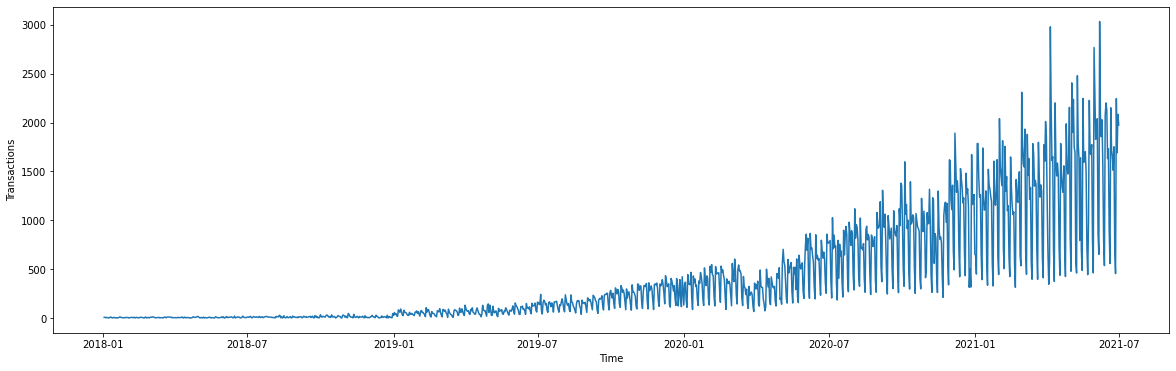

In [10]:
plt.figure(figsize = (20, 6))
plt.xlabel("Time")
plt.ylabel("Transactions")

plt.plot(t2day.date.sort_index())
plt.show()

#### Lets visualize the last year.

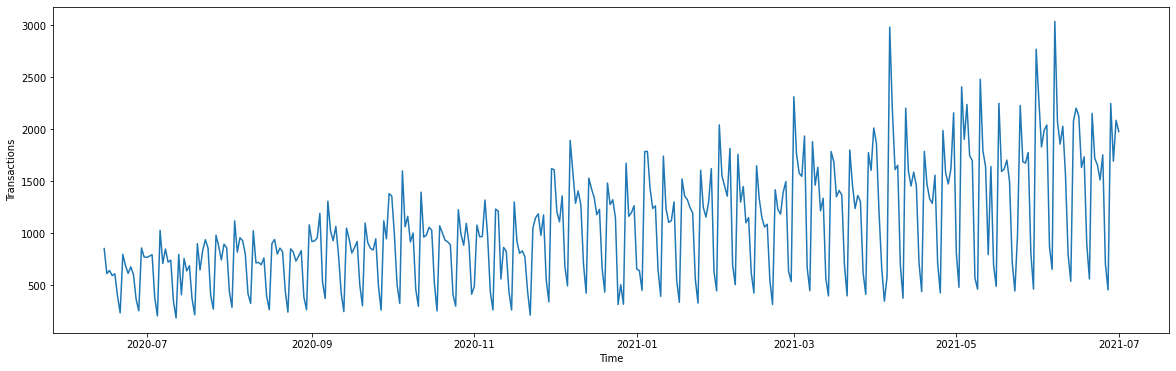

In [11]:
plt.figure(figsize = (20, 6))
plt.xlabel("Time")
plt.ylabel("Transactions")
plt.plot(t2day.date.sort_index()[850:])
plt.plot()
plt.show()

#### Let's visualize the last six months (about 25 weeks)

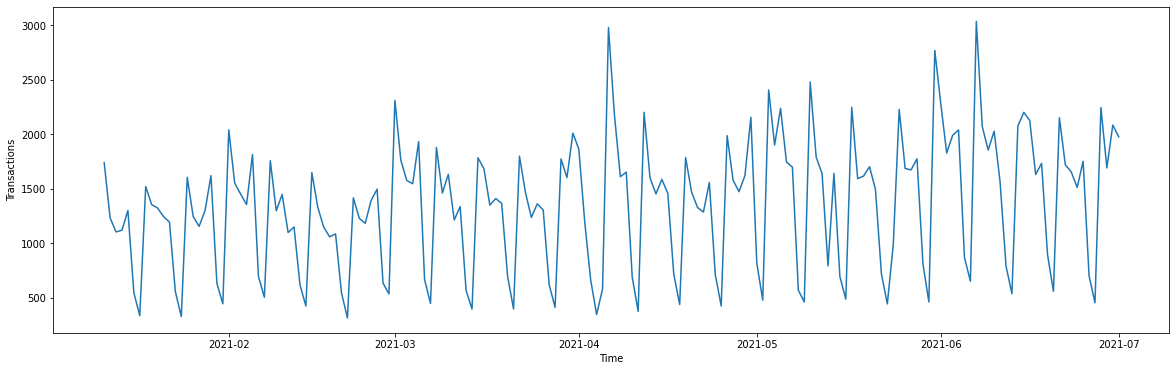

In [12]:
six_months = t2day.date.sort_index()[1060:]

plt.figure(figsize = (20, 6))
plt.xlabel("Time")
plt.ylabel("Transactions")
plt.plot(six_months)
plt.plot()
plt.show()

##### It seems that it has a seasonality of 1 week

#### Data decomposition for obtaining trend, seasonality and residuals

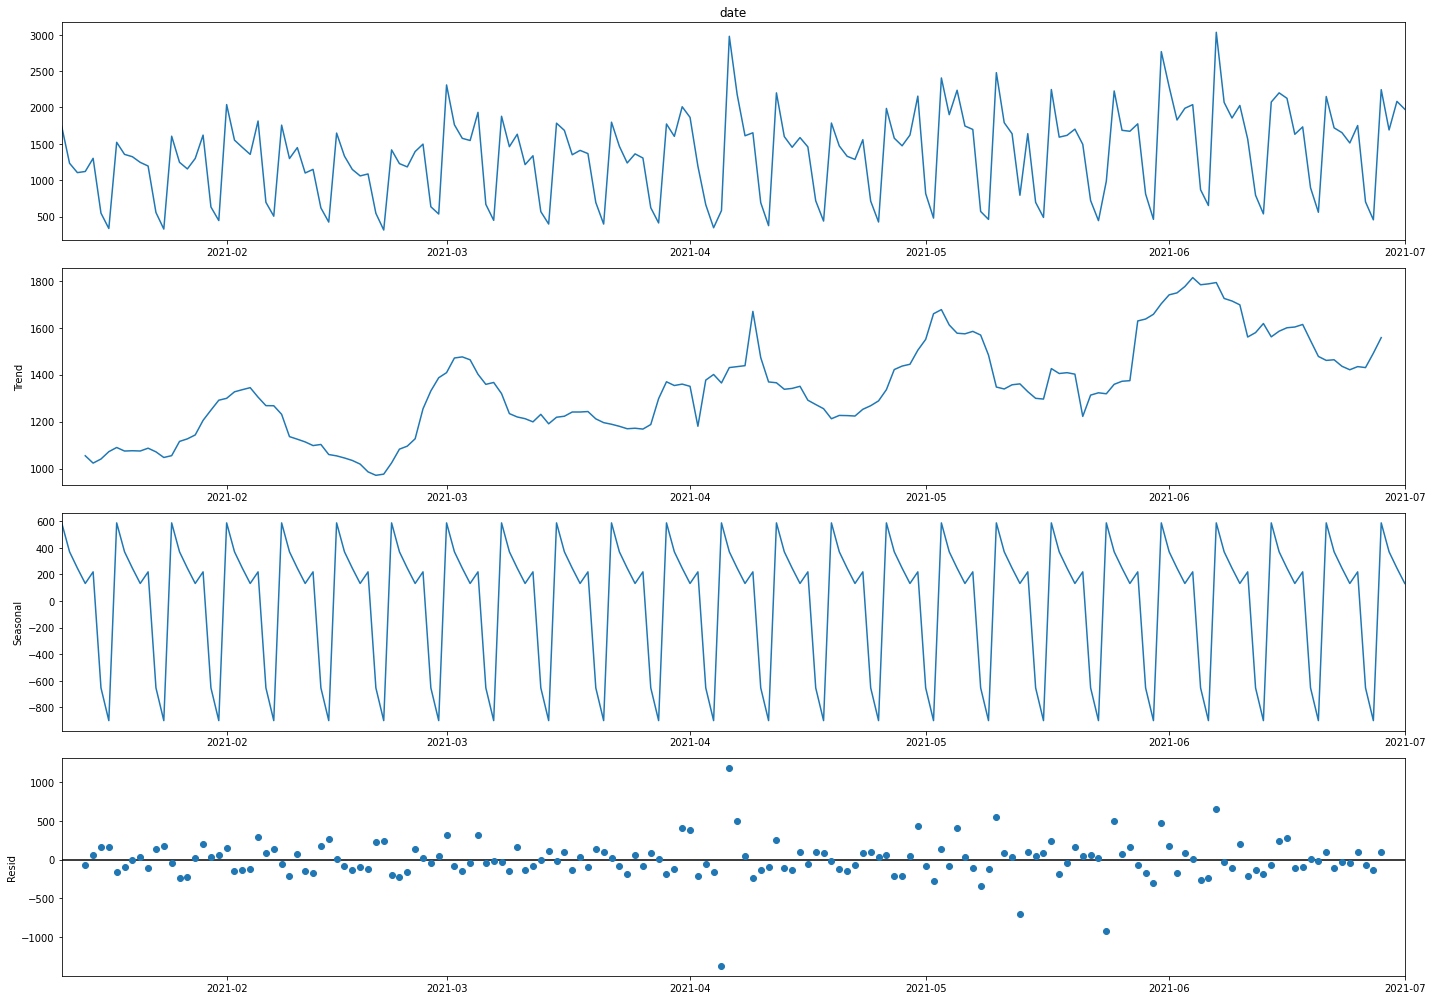

In [14]:
decomp = seasonal_decompose(six_months, model = 'additive')

with plt.rc_context(): 
    plt.rc("figure", figsize = (20, 14))
    decomp.plot()
    plt.show()

##### It seems that most transactions take place during the first days of the week and then fall over the weekend.

#### How are transactions per accounts distributed ?

In [15]:
t2a = transactions['account_id'].value_counts()

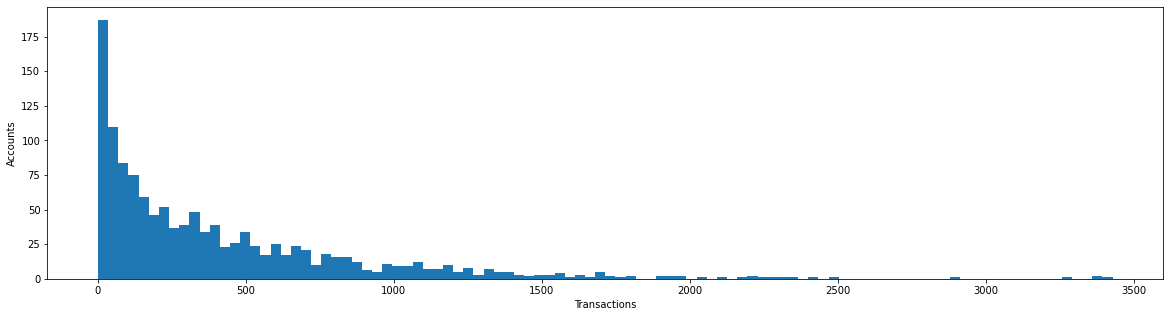

In [16]:
plt.figure(figsize = (20, 5))
plt.xlabel("Transactions")
plt.ylabel("Accounts")

plt.hist(t2a, bins = 100)
plt.show()

#### When is the great majority of the transactions made? During the weekends of during the weekdays?

In [17]:
# the weekdays go from 1-5, while the weekends 6-7
def get_dayofweek(date): 
    data = pd.Timestamp(date)
    dayofweek = date.weekday()
    return dayofweek

transactions['day_of_week'] = transactions['date'].apply(lambda x : get_dayofweek(x))

In [18]:
weekdays_trs = transactions[transactions['day_of_week'] < 6]
weekends_trs = transactions[transactions['day_of_week'] > 5]

In [19]:
print('number of trs during the weekdays = ', len(weekdays_trs))
print('number of trs during the weekends = ', len(weekends_trs))

number of trs during the weekdays =  492244
number of trs during the weekends =  25985


####  When are the negative transactions made ? During the weekdays of during the weekends

In [20]:
neg_trs_weekdays = weekdays_trs[weekdays_trs['amount'] < 0]
neg_trs_weekends = weekends_trs[weekends_trs['amount'] < 0]

In [21]:
print('number of negative trs during the weekdays = ', len(neg_trs_weekdays))
print('number of negative trs during the weekends = ', len(neg_trs_weekends))

number of negative trs during the weekdays =  388259
number of negative trs during the weekends =  22684


In [22]:
print('percentage of negative trs during the weekdays = ',  len(neg_trs_weekdays) / len(weekdays_trs) * 100)
print('percentage of negative trs during the weekends = ',  len(neg_trs_weekends) / len(weekends_trs) * 100)

percentage of negative trs during the weekdays =  78.87531386873177
percentage of negative trs during the weekends =  87.29651722147392


#### Compute and Visualize all the negative transactions

In [23]:
all_negative_trs = transactions[transactions['amount'] < 0]

In [24]:
sorted_neg_trs = all_negative_trs['date'].value_counts().sort_values()
sorted_neg_trs = sorted_neg_trs.to_frame()

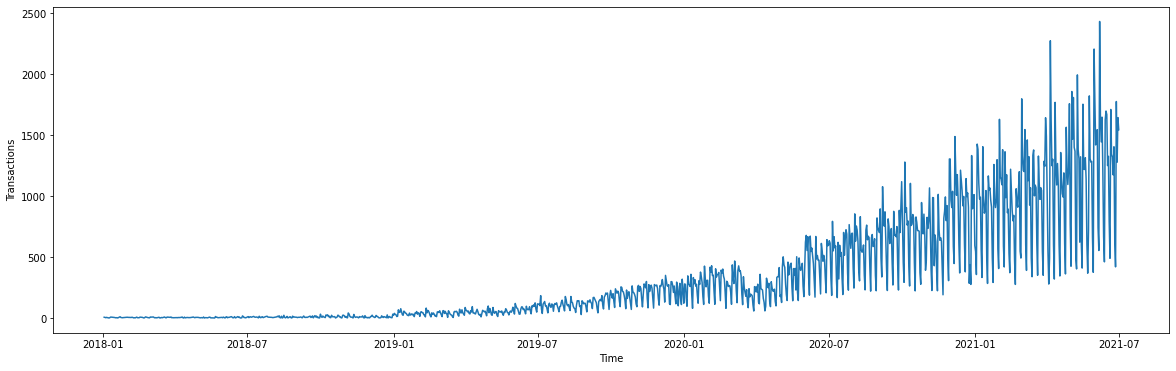

In [25]:
plt.figure(figsize = (20, 6))
plt.xlabel("Time")
plt.ylabel("Transactions")
plt.plot(sorted_neg_trs.date.sort_index())
plt.plot()
plt.show()

## A toy model

#### Apply Autoregression to the data in order to predict number of negative trasactions

In [27]:
# prepare the data for autoregression 
X = sorted_neg_trs.date.sort_index()

In [28]:
# split dataset
prediction_period = 30
train, test = X[1:len(X)- prediction_period], X[len(X)-prediction_period:]

In [36]:
# train autoregression
model = AutoReg(train, lags=22)
model_fit = model.fit()

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

/home/harry/PycharmProjects/timeseries/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/harry/PycharmProjects/timeseries/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/harry/PycharmProjects/timeseries/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


In [58]:
# transform predictions into dataframe and visualize it 
preds = pd.DataFrame(test.index, predictions.values).reset_index()

In [60]:
preds = preds['index'].squeeze()

In [61]:
preds.index = test.index

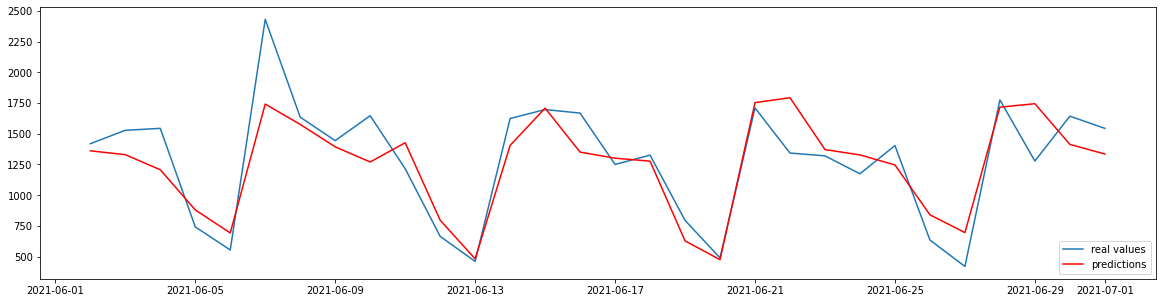

In [62]:
# plot results
plt.figure(figsize=(20, 5))
# Function add a legend  
plt.plot(test)
plt.plot(preds, color='red')
plt.legend(["real values", "predictions"], loc ="lower right")
plt.show()